## Installing libraries
before start, you should have the following libraries in your environment: **matplotlib**, **scipy**, **numpy**, **pandas** and **pymatgen**

In [ ]:
!pip -q install pymatgen

     |████████████████████████████████| 40.6 MB 1.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 292 kB 70.8 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 98 kB 7.4 MB/s 
     |████████████████████████████████| 109 kB 65.0 MB/s 
     |████████████████████████████████| 546 kB 50.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Getting Code
The code can be obtained using `git clone` in the terminal or this notebook

In [ ]:
!git clone https://github.com/GitGreg228/a2f -q

In [ ]:
ls a2f

examples-public/  notebooks/  README.md  requirements.txt  src/


## Starting folder
Please go `src/` folder using `cd`.

In [ ]:
cd a2f/src/

/content/a2f/src


---
# Working example
## Path to the Quantum Espresso outputs
You should have specify the path to the outputs further. In this example, it will be `../examples-public/La2H20`

In [ ]:
ls ../examples-public/La2H20

La2H20.dyn1.elph.1  La2H20.dyn3.elph.3  La2H20.ph.out  results/
La2H20.dyn2.elph.2  La2H20.dyn4.elph.4  README.md


there are four `dyn*.elph.*` and one `ph.out` files present. 

`dyn*.elph.*` contains


1.   q-point coordinates at the Brillouine zone (1st line)
2.   squared frequencies in Ry
3.   DOS at Fermi level $n(ɛ_F)$ in states/spin/Ry/Unit Cell and Fermi level energy $ɛ_F$ in eV
4.   The values of electron-phonon coupling parametes $\lambda_{\mathrm{q}\omega_i}$ and  phonon linewidth $\gamma_{\mathrm{q}\omega_i}$ at given frequencies $\omega_i$ and given q-point coordinate $\mathrm{q}$ (single `dyn*.elph.*` file corresponds to single q-point.)

**Important**: electron-phonon coupling parametes $\lambda_{\mathrm{q}\omega_i}$ and  phonon linewidth $\gamma_{\mathrm{q}\omega_i}$ given in a single `dyn*.elph.*` file  **must be multiplied by q-point weight**. The weights are taken from `ph.out` (or different `ph.out`s if present) where phrase Number of q in the star occurs.



# Explanation of the math operations present in code
The code computes logarithmic average frequency $\omega_{\log}$ and mean square frequency $\omega_2$ in 2 different ways: 


*   **Direct computing** means that these values are computed using lambdas only
*   **$\alpha^2F$ computing** way means that these values are computed by integration of Eliashberg function $\alpha^2F(\omega)$, which is re-created from lambdas.



## Direct computing
Electron-phonon coupling parameter $\lambda$, logarithmic average frequency $\omega_{\log}$, mean square frequency $\omega_2$ can be obtained using:

$$
\lambda = \sum_{\mathrm{q}i} \lambda_{\mathrm{q}\omega_i}
$$
$$
\omega_{\log} = \exp\left[\frac{1}{\lambda} \sum_{\mathrm{q}i} \lambda_{\mathrm{q}\omega_i} \log \omega_i\right]
$$
$$
\omega_2 = \sqrt{\sum_{\mathrm{q}i} \lambda_{\mathrm{q}\omega_i} \omega_i^2}
$$
where $\mathrm{q}$ is q-point, $\lambda_{\mathrm{q}\omega_i}$ and $\omega_i$ are EPC parameter and frequency, respectively.

Note that electron-phonon coupling parameters $\lambda_{\mathrm{q}\omega_i}$ and  phonon linewidths $\gamma_{\mathrm{q}\omega_i}$ (also appears in `dyn*.elph.*`) are connected:

$$
\lambda_{\mathrm{q}\omega_i} = \frac{\gamma_{\mathrm{q}\omega_i}}{\pi n(ɛ_F)\omega_i^2}
$$

and both can be used.

Then you can calculate McMillan $T_{\mathrm{C}}$:

$$
    T_{\mathrm{C}}=\omega_{\log } \frac{f_{1} f_{2}}{1.2} \exp \left[\frac{-1.04(1+\lambda)}{\lambda-\mu^{*}-0.62 \lambda \mu^{*}}\right]
$$

using $f_{1} f_{2}$ = 1, and Allen-Dynes $T_{\mathrm{C}}$ (see [P. Allen, 1975](https://doi.org/10.1103/physrevb.12.905)) using 

$$
    f_{1} f_{2}=\sqrt[3]{1+\left[\frac{\lambda}{2.46\left(1+3.8 \mu^{*}\right)}\right]^{3 / 2}} \nonumber \cdot\left[1-\frac{\lambda^{2}\left(1-\omega_{2} / \omega_{\log }\right)}{\lambda^{2}+3.312\left(1+6.3 \mu^{*}\right)^{2}}\right]
$$

where $\mu^*$ is the Coulomb pseudopotential and usually assumed to be equal to 0.1.

You can also compute Eliashberg function $\alpha^2F(\omega)$ using:

$$
\alpha^2F(\omega) = \frac{1}{2} \sum_{\mathrm{q}i} \lambda_{\mathrm{q}\omega_i} \omega_i \delta(\omega-\omega_i)
$$

**However, such $\alpha^2F(\omega)$ will be very inaccurate.** Indeed, the frequencies $\omega_i$ are not equidistant, thus this $\alpha^2F(\omega)$ can be undefined in a huge frequency range, resulting in a lot of errors during the integration.

## $\alpha^2F(\omega)$ computing

Also, you can get Eliashberg function $\alpha^2F(\omega)$. Indeed, using

$$
    \lambda=\int_{0}^{\omega_{\max }} \frac{2 \alpha^{2} F(\omega)}{\omega} \mathrm{d} \omega
$$

you can easily get 

$$
\alpha^{2} F(\omega_j) = \frac{\omega}{2} \frac{\mathrm{d}\lambda(\omega_j)}{\mathrm{d\omega}}
$$

where $\lambda(\omega_j) = \sum_{i}^{j} \lambda_{\mathrm{q}\omega_i}$

**In the code, $\lambda(\omega_j)$ is interpolated by the linear interpolation to a given resoluting and smoothed by a gaussian filter.** Furtherly, it leads to correct $\alpha^2F(\omega)$ and Eliashberg $T_{\mathrm{C}}$ computing. 

After getting $\alpha^2F(\omega)$, you can re-calculate logarithmic average frequency $\omega_{\log}$ and mean square frequency $\omega_2$:

$$
    \omega_{\log }=\exp \left[\frac{2}{\lambda} \int_{0}^{\omega_{\max }} \frac{\mathrm{d} \omega}{\omega} \alpha^{2} F(\omega) \log (\omega)\right]
$$

and 

$$
    \omega_{2}=\sqrt{\frac{1}{\lambda} \int_{0}^{\omega_{\max }}\left[\frac{2 \alpha^{2} F(\omega)}{\omega}\right] \omega^{2} \mathrm{~d} \omega}
$$

Using new $\omega_{\log}$ and $\omega_2$, you can also re-calculate McMillan and Allen-Dynes $T_{\mathrm{C}}$. 

But most importantly, you now can use smooth $\alpha^2F(\omega)$ for the Eliashberg $T_{\mathrm{C}}$ computations. The method is described in [R. Szczęśniak, 2006](http://dx.doi.org/10.12693%2FAPhysPolA.109.179).



---
# Running the code
run the following command:
```
python main.py -p ../examples-public/La2H20 -r 1000 -s 6 -g 5
```
where `-r` is desired resolution of $\alpha^2F(\omega)$, `-s` is smoothing in THz and `-g` is gaussian filter parameter (does not affect the values of the $\alpha^2F(\omega)$'s integrals)

Full script input parameters are:
1. `-p` - path to the directory with `*.dyn*.elph*` and `output.ph.*` files (default: `.`)
2. `-s` - exponential smoothing parameter in THz, used to remove acoustic frequencies (default: 3)
3. `-r` - desired resolution of the a2f function (default: cumulative number of positive frequencies in all `*dyn*.elph*` files)
4. `-g` - sigma in gaussian filter used for smoothing (default: 1)
5. `--mu` - Coulomb pseudopotential (default: 0.1)
6. `--tol` - structure tolerance in angstrom (default: 0.2)

In [ ]:
!python main.py -p ../examples-public/La2H20 -r 1000 -s 6 -g 5

Found dyn_elphs in ../examples-public/La2H20/La2H20.dyn2.elph.2, ../examples-public/La2H20/La2H20.dyn3.elph.3, ../examples-public/La2H20/La2H20.dyn4.elph.4, ../examples-public/La2H20/La2H20.dyn1.elph.1
Found ph.outs in ../examples-public/La2H20/La2H20.ph.out

The structure under consideration is 2x of Fm-3m-LaH10.
q = (0.167, 0.167, 0.177) with number of q in the star 8
q = (0.167, -0.500, 0.177) with number of q in the star 4
q = (-0.500, 0.167, 0.177) with number of q in the star 4
q = (-0.500, -0.500, 0.177) with number of q in the star 2
With the smoothing of 6 THz, direct lambda = 3.184, direct wlog = 902 K, direct w2 = 1220 K.
After calculating alpha2f on resolution r = 1000 and applying gaussian filter with sigma = 5, interp lambda = 3.186, interp wlog = 924 K, interp w2 = 1229 K.
Mu = 0.1. Calculated McMillan Tc = 166.468 (170.625) K, calculated Allen-Dynes Tc = 245.383 (245.383) K
/content/a2f/src/plotters.py:147: UserWarning: This figure includes Axes that are not compatible 

You can then observe the results folder

In [ ]:
ls ../examples-public/La2H20

La2H20.dyn1.elph.1  La2H20.dyn3.elph.3  La2H20.ph.out  results/
La2H20.dyn2.elph.2  La2H20.dyn4.elph.4  README.md


---
# Observing the results
`results/` directory contains the following files:

In [ ]:
!ls ../examples-public/La2H20/results

2xLaH10.vasp	     direct_s6.csv  plot_article_LaH10.pdf  result.json
a2f_s6_r1000_g5.csv  LaH10_225.cif  plot_s6_r1000_g5.pdf


## Crysal structures

*   `2xLaH10.vasp` represents the structure taken from `La2H20.ph.out`
*   `LaH10_225.cif` contains symmetrized structure


In [ ]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [ ]:
struc = Structure.from_file('../examples-public/La2H20/results/LaH10_225.cif')
symmetrized_struc = SpacegroupAnalyzer(struc, symprec=0.01).get_symmetrized_structure()
print(symmetrized_struc)

SymmetrizedStructure
Full Formula (La4 H40)
Reduced Formula: LaH10
Spacegroup: Fm-3m (225)
abc   :   4.986441   4.986441   4.986441
angles:  90.000000  90.000000  90.000000
Sites (44)
  #  SP           a         b         c  Wyckoff
---  ----  --------  --------  --------  ---------
  0  La    0         0         0.5       4b
  1  H     0.120522  0.120522  0.120522  32f
  2  H     0.25      0.25      0.25      8c


## `.csv` tables with superconducting parameters depending on $\omega$

*   `direct_s6.csv` file contains $\lambda$, $\omega_{\log}$, $\omega_2$ and $T_{\mathrm{C}}$ (both McMillan and Allen-Dynes) and their dependence on $\omega$. These values were computed directly from numbers given `dyn*.elph.*`.
*   `a2f_s6_r1000_g5.csv` contains values same as above + Eliashberg function $\alpha^2f(\omega)$, which was interpolated and used for their computations via integral.

In [ ]:
import pandas as pd

In [ ]:
direct = pd.read_csv('../examples-public/La2H20/results/direct_s6.csv', sep='[	\t]', engine='python')
print(direct.keys())

Index(['freqs, THz', 'a2f (lambda), THz', 'a2f (gamma), THz',
       'lambdas (lambda)', 'lambdas (gamma)', 'lambda (lambda)',
       'lambda (gamma)', 'wlogs (lambda), K', 'wlogs (gamma), K',
       'wlog (lambda), K', 'wlog (gamma), K', 'w2s (lambda), K',
       'w2s (gamma), K', 'w2 (lambda), K', 'w2 (gamma), K',
       'Tc_McM (lambda), K', 'Tc_McM (gamma), K', 'Tc_AD (lambda), K',
       'Tc_AD (gamma), K'],
      dtype='object')


In [ ]:
display(direct)

,"freqs, THz","a2f (lambda), THz","a2f (gamma), THz",lambdas (lambda),lambdas (gamma),lambda (lambda),lambda (gamma),"wlogs (lambda), K","wlogs (gamma), K","wlog (lambda), K","wlog (gamma), K","w2s (lambda), K","w2s (gamma), K","w2 (lambda), K","w2 (gamma), K","Tc_McM (lambda), K","Tc_McM (gamma), K","Tc_AD (lambda), K","Tc_AD (gamma), K"
0,-58.676094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-57.532114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-57.369252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-57.012241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-56.757193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,67.311761,0.010017,0.010186,0.000298,0.000303,3.181641,3.181641,0.000755,0.000768,898.5,898.5,975.576335,992.066286,1216.587396,1216.624216,165.821844,165.821844,244.426082,244.431035
260,71.099680,0.013727,0.013582,0.000386,0.000382,3.181641,3.181641,0.000987,0.000976,898.5,898.5,1412.136891,1397.199929,1216.988278,1217.031860,165.821844,165.821844,244.426082,244.431035
261,72.285360,0.017548,0.017520,0.000486,0.000485,3.181641,3.181641,0.001243,0.001241,902.0,902.0,1835.386220,1832.356532,1217.568317,1217.605744,166.467783,166.467783,245.378215,245.383187
262,78.962211,0.025297,0.025393,0.000641,0.000643,3.181641,3.183594,0.001658,0.001665,902.0,902.0,2890.182825,2901.059189,1218.321793,1218.357954,166.467783,166.467783,245.378215,245.383187


In [ ]:
a2f = pd.read_csv('../examples-public/La2H20/results/a2f_s6_r1000_g5.csv', sep='[	\t]', engine='python')
print(a2f.keys())

Index(['freqs, THz', 'a2f (lambda), THz', 'a2f (gamma), THz',
       'lambda (lambda)', 'lambda (gamma)', 'wlog (lambda), K',
       'wlog (gamma), K', 'w2 (lambda), K', 'w2 (gamma), K',
       'Tc_McM (lambda), K', 'Tc_McM (gamma), K', 'Tc_AD (lambda), K',
       'Tc_AD (gamma), K'],
      dtype='object')


In [ ]:
display(a2f)

,"freqs, THz","a2f (lambda), THz","a2f (gamma), THz",lambda (lambda),lambda (gamma),"wlog (lambda), K","wlog (gamma), K","w2 (lambda), K","w2 (gamma), K","Tc_McM (lambda), K","Tc_McM (gamma), K","Tc_AD (lambda), K","Tc_AD (gamma), K"
0,0.176914,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
1,0.256078,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,0.000000,0.000000,0.18457,0.18457,0.269531,0.269531
2,0.335243,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,0.000000,0.000000,0.18457,0.18457,0.269531,0.269531
3,0.414407,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,0.000000,0.000000,0.18457,0.18457,0.269531,0.269531
4,0.493572,2.600000e-10,2.600000e-10,8.300000e-11,8.300000e-11,1.0,1.0,0.000121,0.000121,0.18457,0.18457,0.269531,0.269531
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,78.945570,1.016959e-01,6.965389e-03,3.185296e+00,3.186290e+00,924.0,924.0,1229.000000,1229.000000,170.62500,170.62500,249.125000,249.125000
996,79.024734,1.160349e-01,6.327737e-03,3.185528e+00,3.186303e+00,924.0,924.0,1229.000000,1229.000000,170.62500,170.62500,249.125000,249.125000
997,79.103899,1.280769e-01,5.791856e-03,3.185784e+00,3.186314e+00,924.0,924.0,1229.000000,1229.000000,170.62500,170.62500,249.125000,249.125000
998,79.183063,1.367789e-01,5.404429e-03,3.186058e+00,3.186325e+00,924.0,924.0,1229.000000,1229.000000,170.62500,170.62500,249.125000,249.125000


This data will be used for futher plots. You can use it for your own plotting.

## Plots
**Warning**: following `apt-get` command is used for Google Colab. If you don't work in colab, probably using some other pdf reader will be better.

In [ ]:
!apt-get install poppler-utils -qq

Selecting previously unselected package poppler-utils.
(Reading database ... 155514 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!pip install -q pdf2image

In [ ]:
from pdf2image import convert_from_path
from IPython.display import display, Image

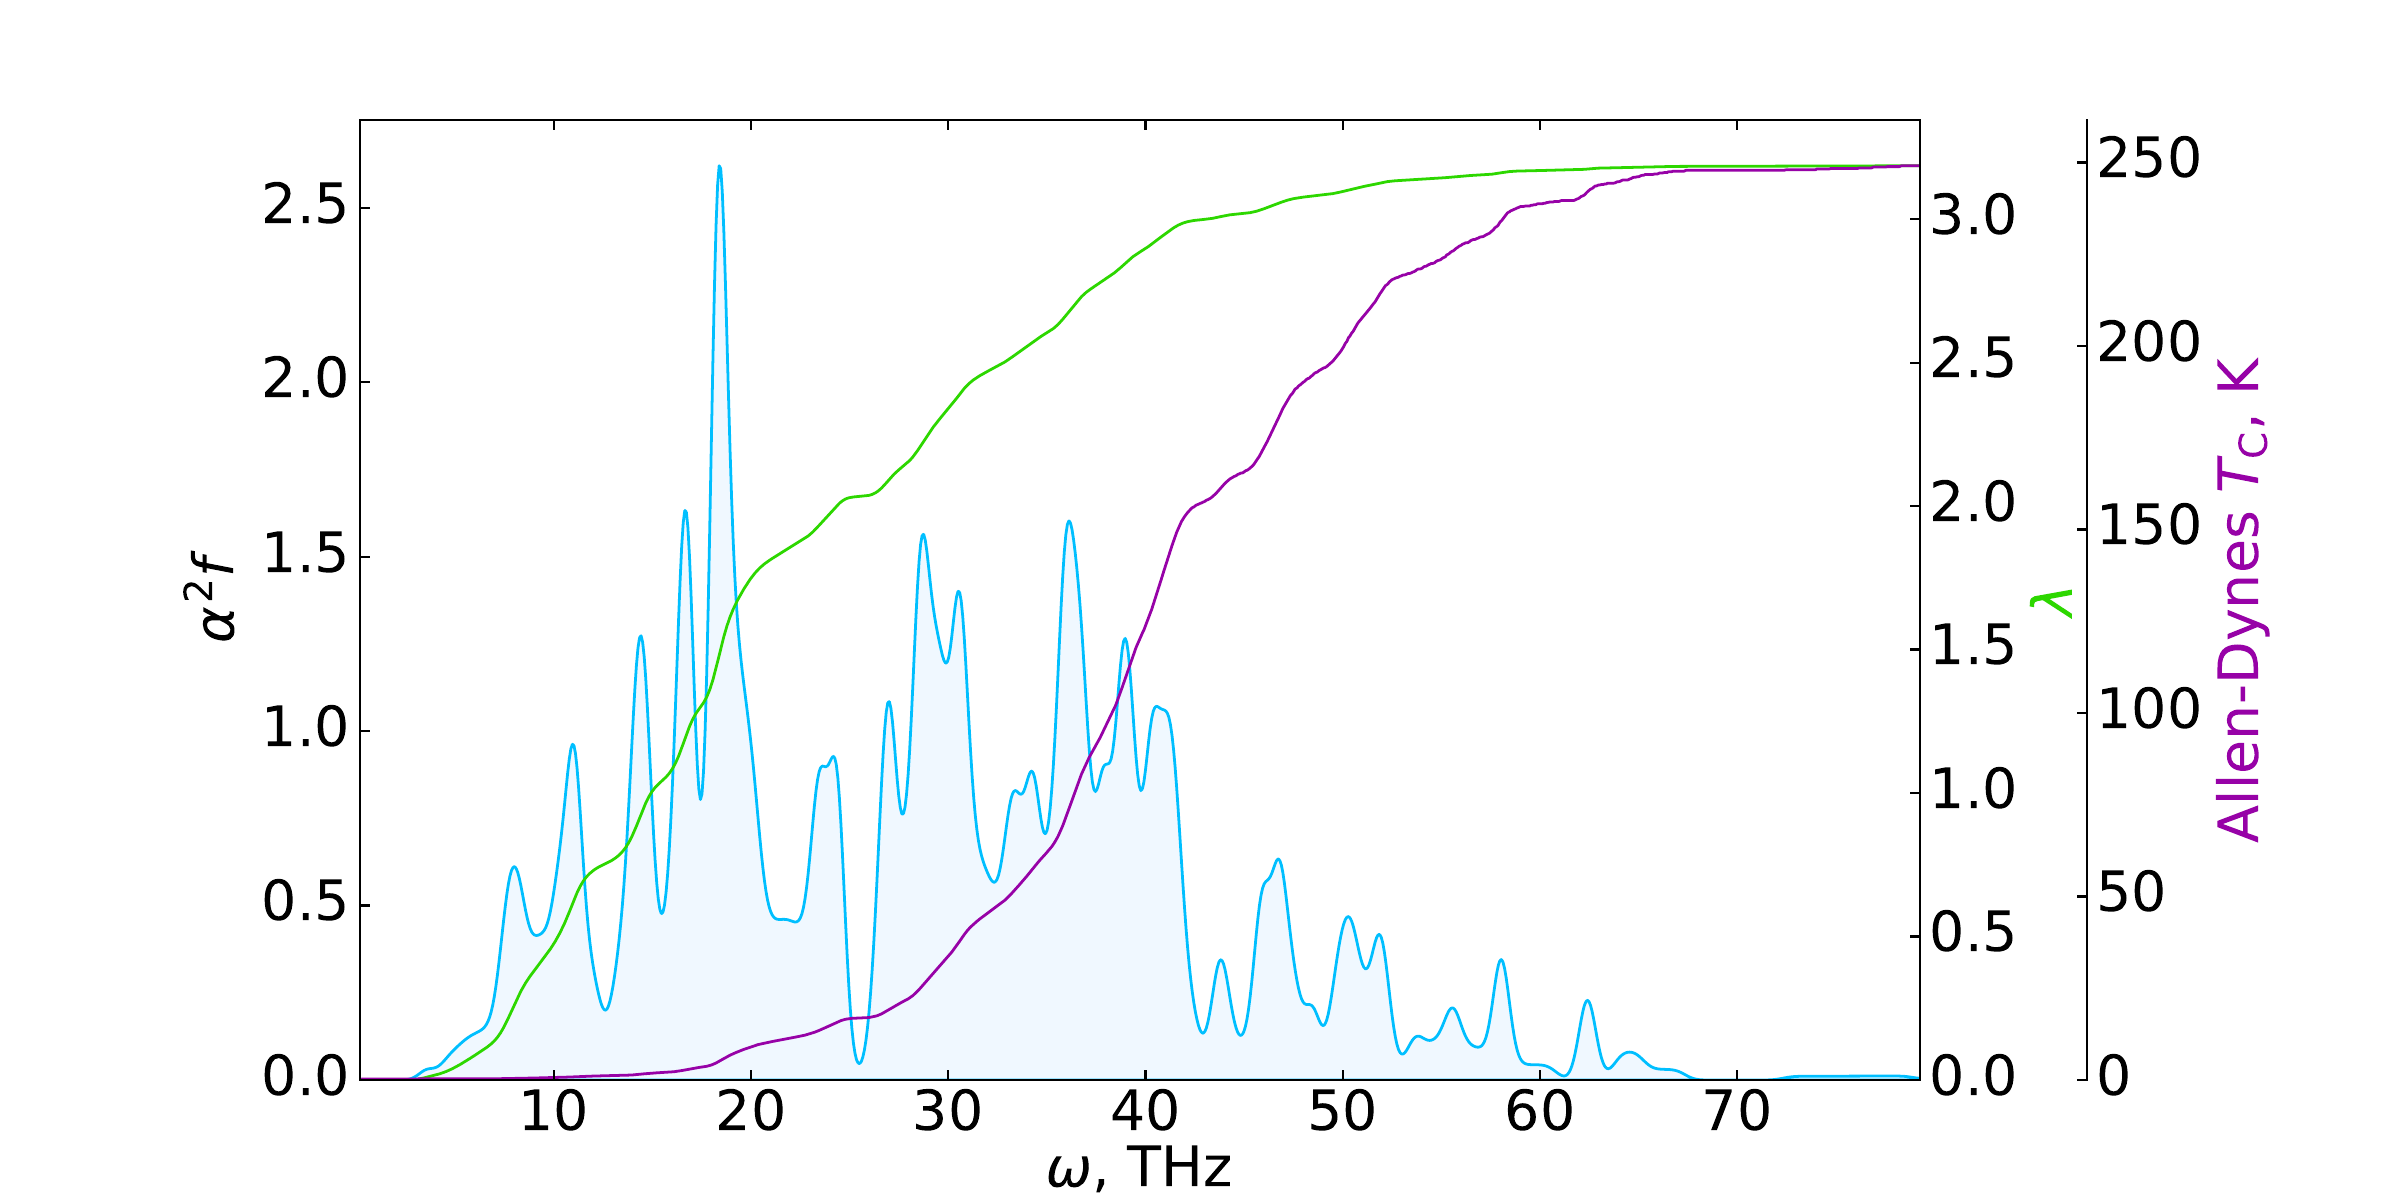

In [ ]:
images = convert_from_path('../examples-public/La2H20/results/plot_article_LaH10.pdf')
for i, image in enumerate(images):    
    fname = "image" + str(i) + ".png"
    image.save(fname, "PNG")
Image(fname, width=600, height=300)

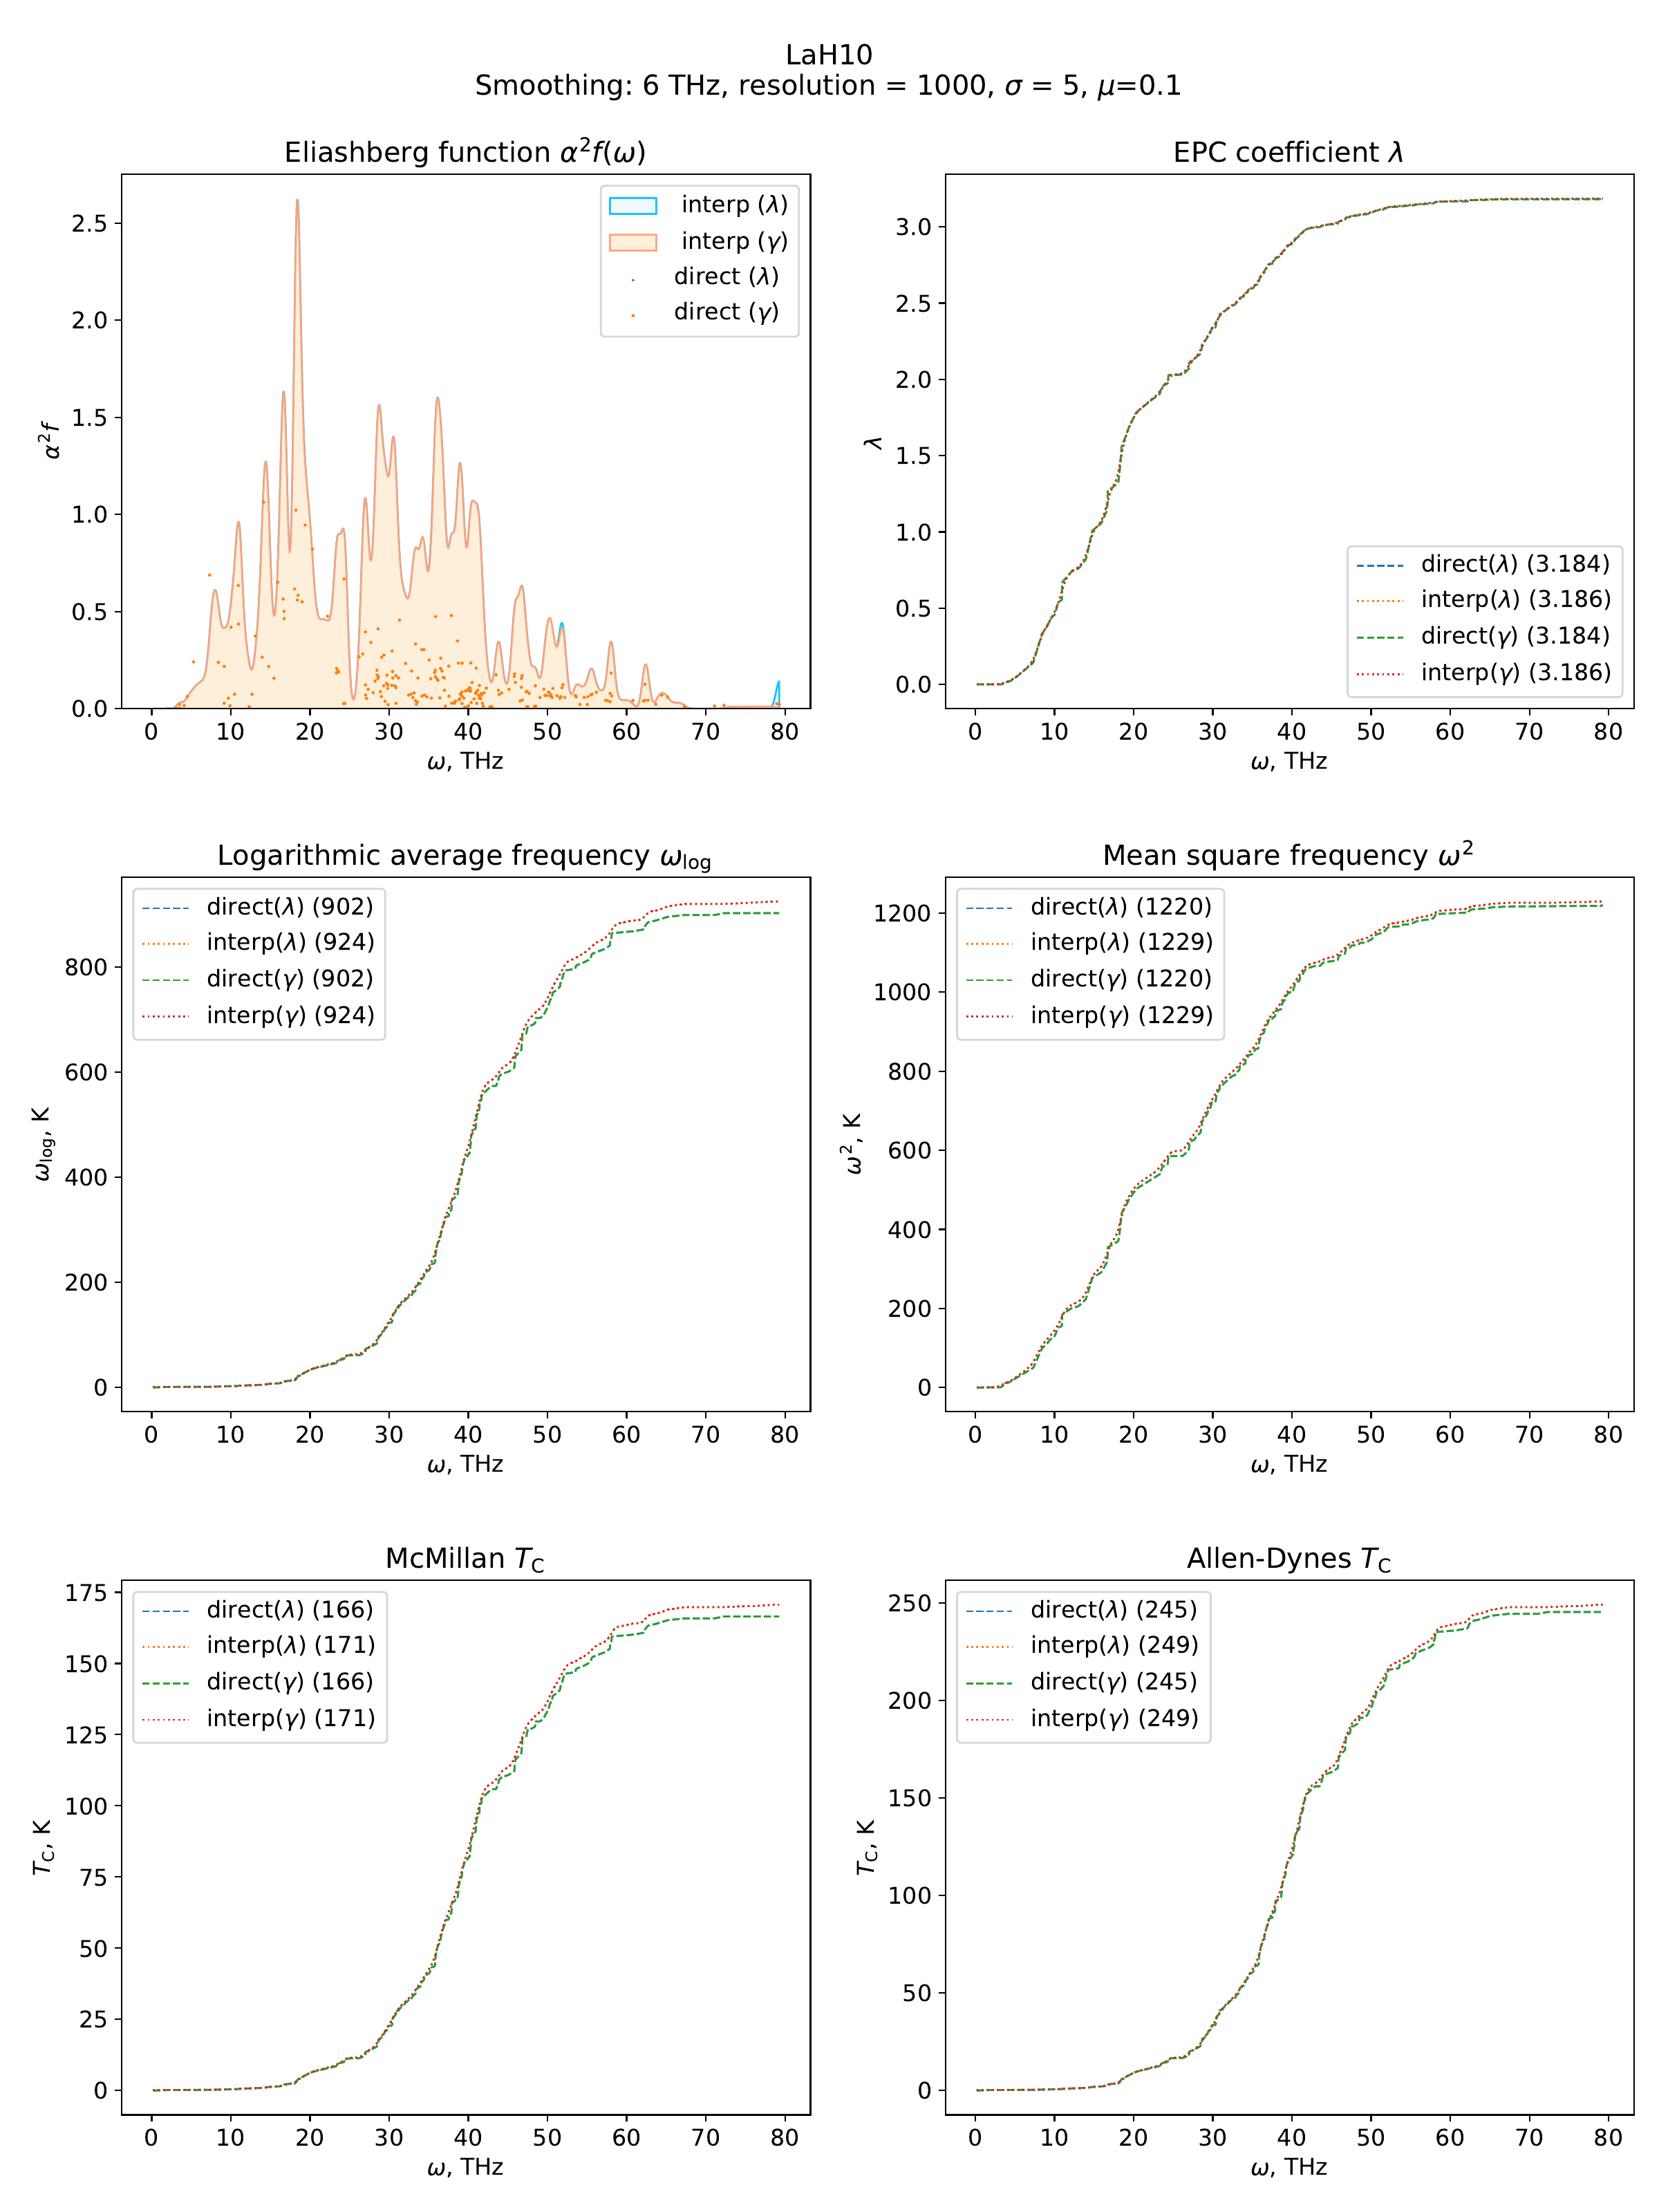

In [ ]:
images = convert_from_path('../examples-public/La2H20/results/plot_s6_r1000_g5.pdf')
for i, image in enumerate(images):    
    fname = "image" + str(i) + ".png"
    image.save(fname, "PNG")
Image(fname, width=600, height=800)

You can observe electron-phonon coupling parameter $\lambda$, logarithmic average frequency $\omega_{\log}$, mean square frequency $\omega_2$ and superconducting critical temperature $T_{\mathrm{C}}$ (both McMillan and Allen-Dynes).

## Parameters of the superconducting state

### Explanation of the paramters of superconducting state (see [J. Carbotte, 1990](https://doi.org/10.1103/RevModPhys.62.1027), pages 51-58)

Sommerfeld constant is defined as

$$
\gamma=\frac{2}{3} \pi^{2} k_{\mathrm{B}}^{2} n(ɛ_F) (1+\lambda)
$$
where $k_{\mathrm{B}}$ is Boltzmann constant, $n(ɛ_F)$ is DOS at Fermi level and  $\lambda$ is electron-phonon coupling parameter. 

Units of Sommerfeld constant $\gamma$ are usually $\frac{\mathrm{mJ}}{\mathrm{mol}\cdot\mathrm{K}^2}$ or $\frac{\mathrm{mJ}}{\mathrm{\overset{\circ}{A}^3} \cdot\mathrm{K}^2}$

Using $\gamma$, we can obtain specific heat jump $\Delta C$ in $\frac{\mathrm{mJ}}{\mathrm{mol}\cdot\mathrm{K}^2}$

$$
\frac{\Delta C\left(T_{c}\right)}{\gamma T_{c}}=1.43\left[1+53\left(\frac{T_{c}}{\omega_{\log }}\right)^{2} \ln \left(\frac{\omega_{\log }}{3 T_{c}}\right)\right]
$$

and upper critical field in T using 

$$
    \frac{\gamma T_{\mathrm{C}}^{2}}{H_{\mathrm{C}}^{2}(0)}=0.168\left[1-12.2\left(\frac{T_{\mathrm{C}}}{\omega_{\log }}\right)^{2} \ln \left(\frac{\omega_{\log }}{3 T_{\mathrm{C}}}\right)\right]
$$

**Important**:

1. For the last formula, you must use $\gamma$ in $\frac{\mathrm{J}}{\mathrm{mol}\cdot\mathrm{K}^2}$ and $T_{\mathrm{C}}$ in K only. The resulting $H_{\mathrm{C}}$'s units, however, will be T.
2. This $H_{\mathrm{C}}$ is close to the experimental values of pure sample. Real value should be calculated taking into account doping concentration.
3. In the code, Eliashberg $T_{\mathrm{C}}$ is used

You can also calculate superconducting gap $\Delta$

$$
    \frac{2 \Delta(0)}{k_{\mathrm{B}} T_{\mathrm{C}}}=3.53\left[1+12.5\left(\frac{T_{\mathrm{C}}}{\omega_{\log }}\right)^{2} \ln \left(\frac{\omega_{\log }}{2 T_{\mathrm{C}}}\right)\right]
$$
Its units are any energy units you desire.

The program computes parameters of superconducting state and saves them in `result.json`.

You can get these parameters using `json.load()`

In [ ]:
import json

In [ ]:
with open('../examples-public/La2H20/results/result.json', 'r') as f:
    params = json.load(f)

Thus, the superconducting critical temperature $T_{\mathrm{C}}$ of LaH$_{10}$ is

In [ ]:
display(params['Tc, K']['Eliashberg'])

265.305

the Sommerfeld constant is

In [ ]:
display(params['Sommerfeld gamma'])

{'mJ/A^3/K^2': '4.993172E-25', 'mJ/g/K^2': 0.06256, 'mJ/mol/K^2': 9.321}

the upper critical field $H_{\mathrm{C}}$ is

In [ ]:
display(params['Hc2, T'])

[94.859]

The specific heat jump $\frac{\Delta C}{T_{\mathrm{C}}}$ is

In [ ]:
display(params['DeltaC/Tc'])

{'mJ/A^3/K^2': '1.123665E-24', 'mJ/g/K^2': 0.141, 'mJ/mol/K^2': 20.975}

The superconducting gap $\Delta(0)$ is

In [ ]:
display(params['Delta'])

{'2Delta/kBTc': 5.555, 'J': '1.017458E-20', 'meV': 63.505}

The overall parameters are following:

In [ ]:
!cat ../examples-public/La2H20/results/result.json

{
    "formula": "LaH10",
    "# of chemical formula units (f.u.)": 2,
    "Smoothing, THz": 6,
    "Resolution, pts": 1000,
    "mu": 0.1,
    "volume, A^3": 61.993,
    "volume of chemical formula unit, A^3": 30.996,
    "density, g/cm^3": 7.981,
    "lambda": {
        "direct": {
            "lambda": 3.184,
            "gamma": 3.184
        },
        "a2f": {
            "lambda": 3.186,
            "gamma": 3.186
        }
    },
    "wlog, K": {
        "direct": {
            "lambda": 902,
            "gamma": 902
        },
        "a2f": {
            "lambda": 924,
            "gamma": 924
        }
    },
    "w2, K": {
        "direct": {
            "lambda": 1219,
            "gamma": 1219
        },
        "a2f": {
            "lambda": 1229,
            "gamma": 1229
        }
    },
    "Tc, K": {
        "McMillan": {
            "direct": {
                "lambda": 166.468,
                "gamma": 166.468
            },
            "a2f": {
                "la